# Select samples for use in longitudinal analysis of YA and OA cohorts

## Load packages

In [1]:
quiet_library <- function(...) { suppressPackageStartupMessages(library(...)) }
quiet_library(hise)
quiet_library(dplyr)
quiet_library(purrr)
quiet_library(ggplot2)

## Retrieve file and sample metadata from HISE

In [2]:
BR1_rna_desc <- getFileDescriptors(
    fileType = "scRNA-seq-labeled", 
    filter = list(cohort.cohortGuid = "BR1"))
BR2_rna_desc <- getFileDescriptors(
    fileType = "scRNA-seq-labeled", 
    filter = list(cohort.cohortGuid = "BR2"))

In [3]:
BR1_rna_desc <- fileDescToDataframe(BR1_rna_desc)
BR2_rna_desc <- fileDescToDataframe(BR2_rna_desc)

## Remove irrelevant batches

Batches starting with "EXP" are experimental, non-pipeline batches.  
B004 is an early batch that has some batch effects. We'll exclude this batch, as samples have been re-run in later batches.

In [4]:
meta_data <- plyr::rbind.fill(BR1_rna_desc , BR2_rna_desc )

In [5]:
meta_data <- meta_data %>%
  filter(!grepl("EXP",file.batchID)) %>%
  filter(!file.batchID == "B004")

## Remove non-healthy and abnormal subjects

We want to use only healthy subjects without abnormal presentation for this reference. A few subjects have non-healthy or abnormal states recored at some visits. We'll identify and remove these subjects.

In [6]:
non_healthy <- meta_data %>%
  filter(sample.diseaseStatesRecordedAtVisit != "") %>%
  select(subject.subjectGuid, sample.diseaseStatesRecordedAtVisit) %>%
  unique()

In [7]:
non_healthy

,subject.subjectGuid,sample.diseaseStatesRecordedAtVisit
,<chr>,<chr>
1,BR1034,Psoriasis
8,BR2007,Healthy - Abnormal
9,BR2049,Healthy - Abnormal


In [8]:
meta_data <- meta_data %>%
  filter(!subject.subjectGuid %in% non_healthy$subject.subjectGuid)

## Select Non-Flu Year 1 Day 0 samples

To build our cell type reference, we used the pre-vaccination samples from each of our BR1 (healthy adult 25-35 years) and BR2 (healthy adult 55-65 years) subjects. These samples have the visit name "Flu Year 1 Day 0". We'll read in the set of files that we utilized in reference labeling to flag which samples were used.

For analysis, we'll use these samples, but we'll also need the set of samples from other visits to enable analysis of longitudinal changes.

In [9]:
reference_sample_uuid <- '2da66a1a-17cc-498b-9129-6858cf639caf'

In [10]:
hise_res <- cacheFiles(list(reference_sample_uuid))

In [11]:
reference_meta <- read.csv("cache/2da66a1a-17cc-498b-9129-6858cf639caf/ref_h5_meta_data_2024-02-18.csv")

Because there may be some samples that were re-run in later batches, but we'd like to utilize the version in our reference dataset, we'll need to identify samples with matching kits and make sure we use the same file.id for our reference samples.

In [12]:
meta_data$pbmc_sample_id <- gsub("_","",paste0("PB0",substr(sub(".*PB0", "", meta_data$file.name),1,8)))

In [13]:
reference_meta_data <- meta_data %>%
  filter(sample.sampleKitGuid %in% reference_meta$sample.sampleKitGuid) %>%
  filter(file.id %in% reference_meta$file.id) %>%
  mutate(sample.reference = "in_reference")

For non-reference samples, we'll obtain data from the most recent available batch by selecting the last pbmc_sample_id (last aliquot used for the pipeline)

In [14]:
non_reference_meta_data <- meta_data %>%
  filter(!sample.sampleKitGuid %in% reference_meta$sample.sampleKitGuid) %>%
  arrange(pbmc_sample_id) %>%
  filter(!duplicated(sample.sampleKitGuid, fromLast = TRUE)) %>%
  mutate(sample.reference = "not_in_reference")

Now, we'll join these back together

In [15]:
meta_data <- rbind(reference_meta_data, non_reference_meta_data)
meta_data <- meta_data %>%
  arrange(sample.sampleKitGuid)

In [16]:
table(meta_data$sample.reference)


    in_reference not_in_reference 
              92              776 

How many files are available?

In [17]:
nrow(meta_data)

[1] 868

How many per cohort?

In [18]:
table(meta_data$cohort.cohortGuid)


BR1 BR2 
418 450 

How many per subject?

In [19]:
meta_data <- meta_data %>%
  mutate(sample.visitName = ifelse(
      sample.visitName == "Other - Non-Flu",
      sample.visitDetails, sample.visitName
  ))

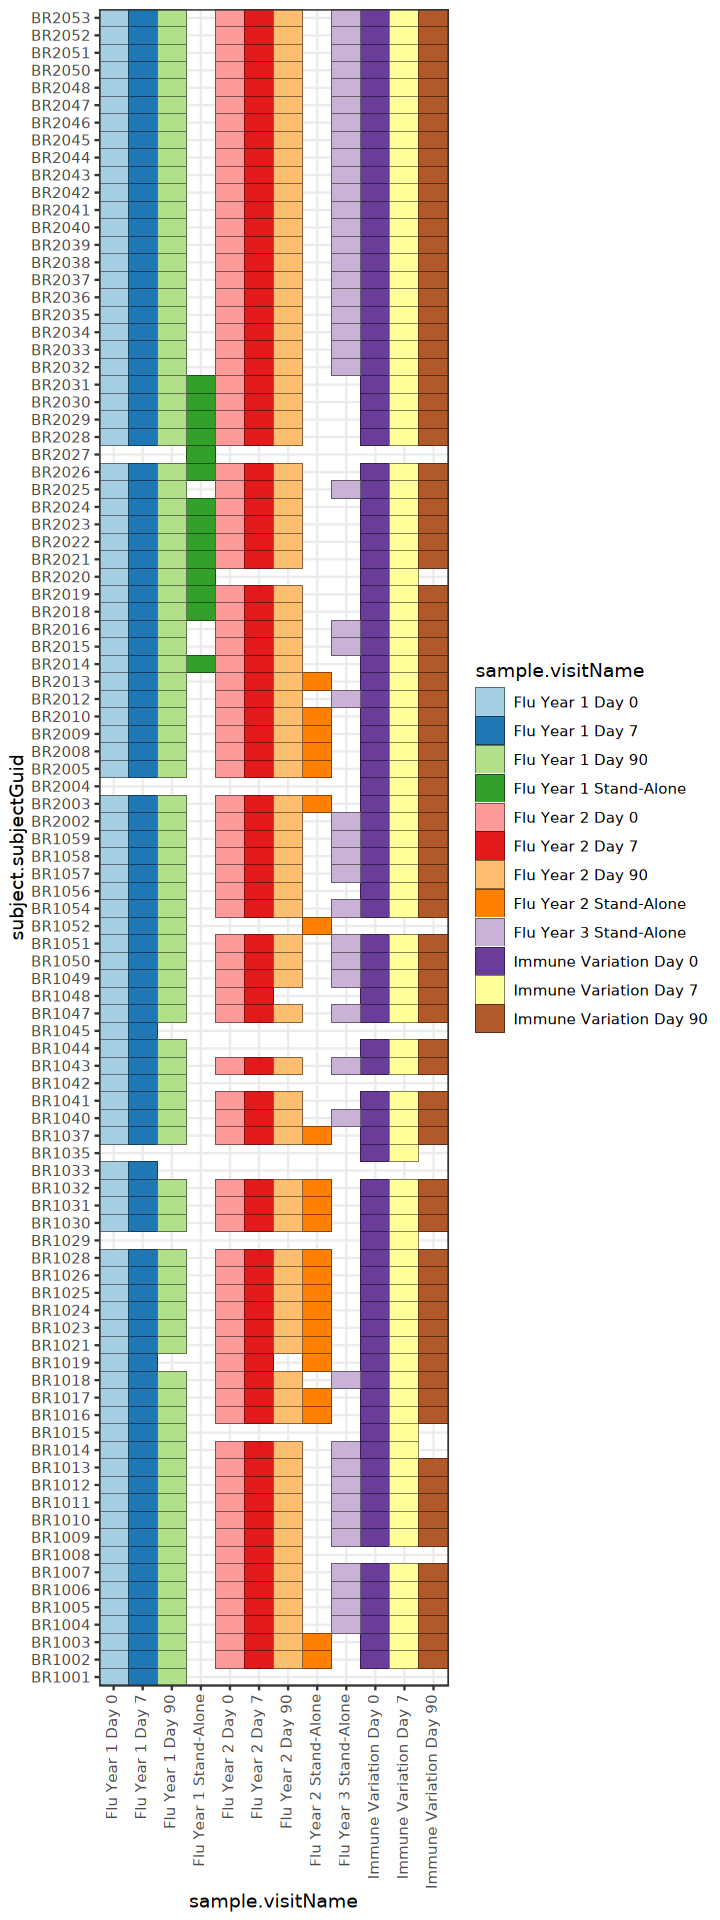

In [20]:
options(repr.plot.width = 6, repr.plot.height = 16)
ggplot() +
  geom_tile(
      data = meta_data,
      aes(x = sample.visitName,
          y = subject.subjectGuid,
          fill = sample.visitName),
      color = "black"
  ) +
  scale_fill_brewer(
      type = "qual",
      palette = 3
  ) +
  scale_x_discrete(expand = c(0,0)) +
  scale_y_discrete(expand = c(0,0)) +
  theme_bw() +
  theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.3))

What's the batch distribution?

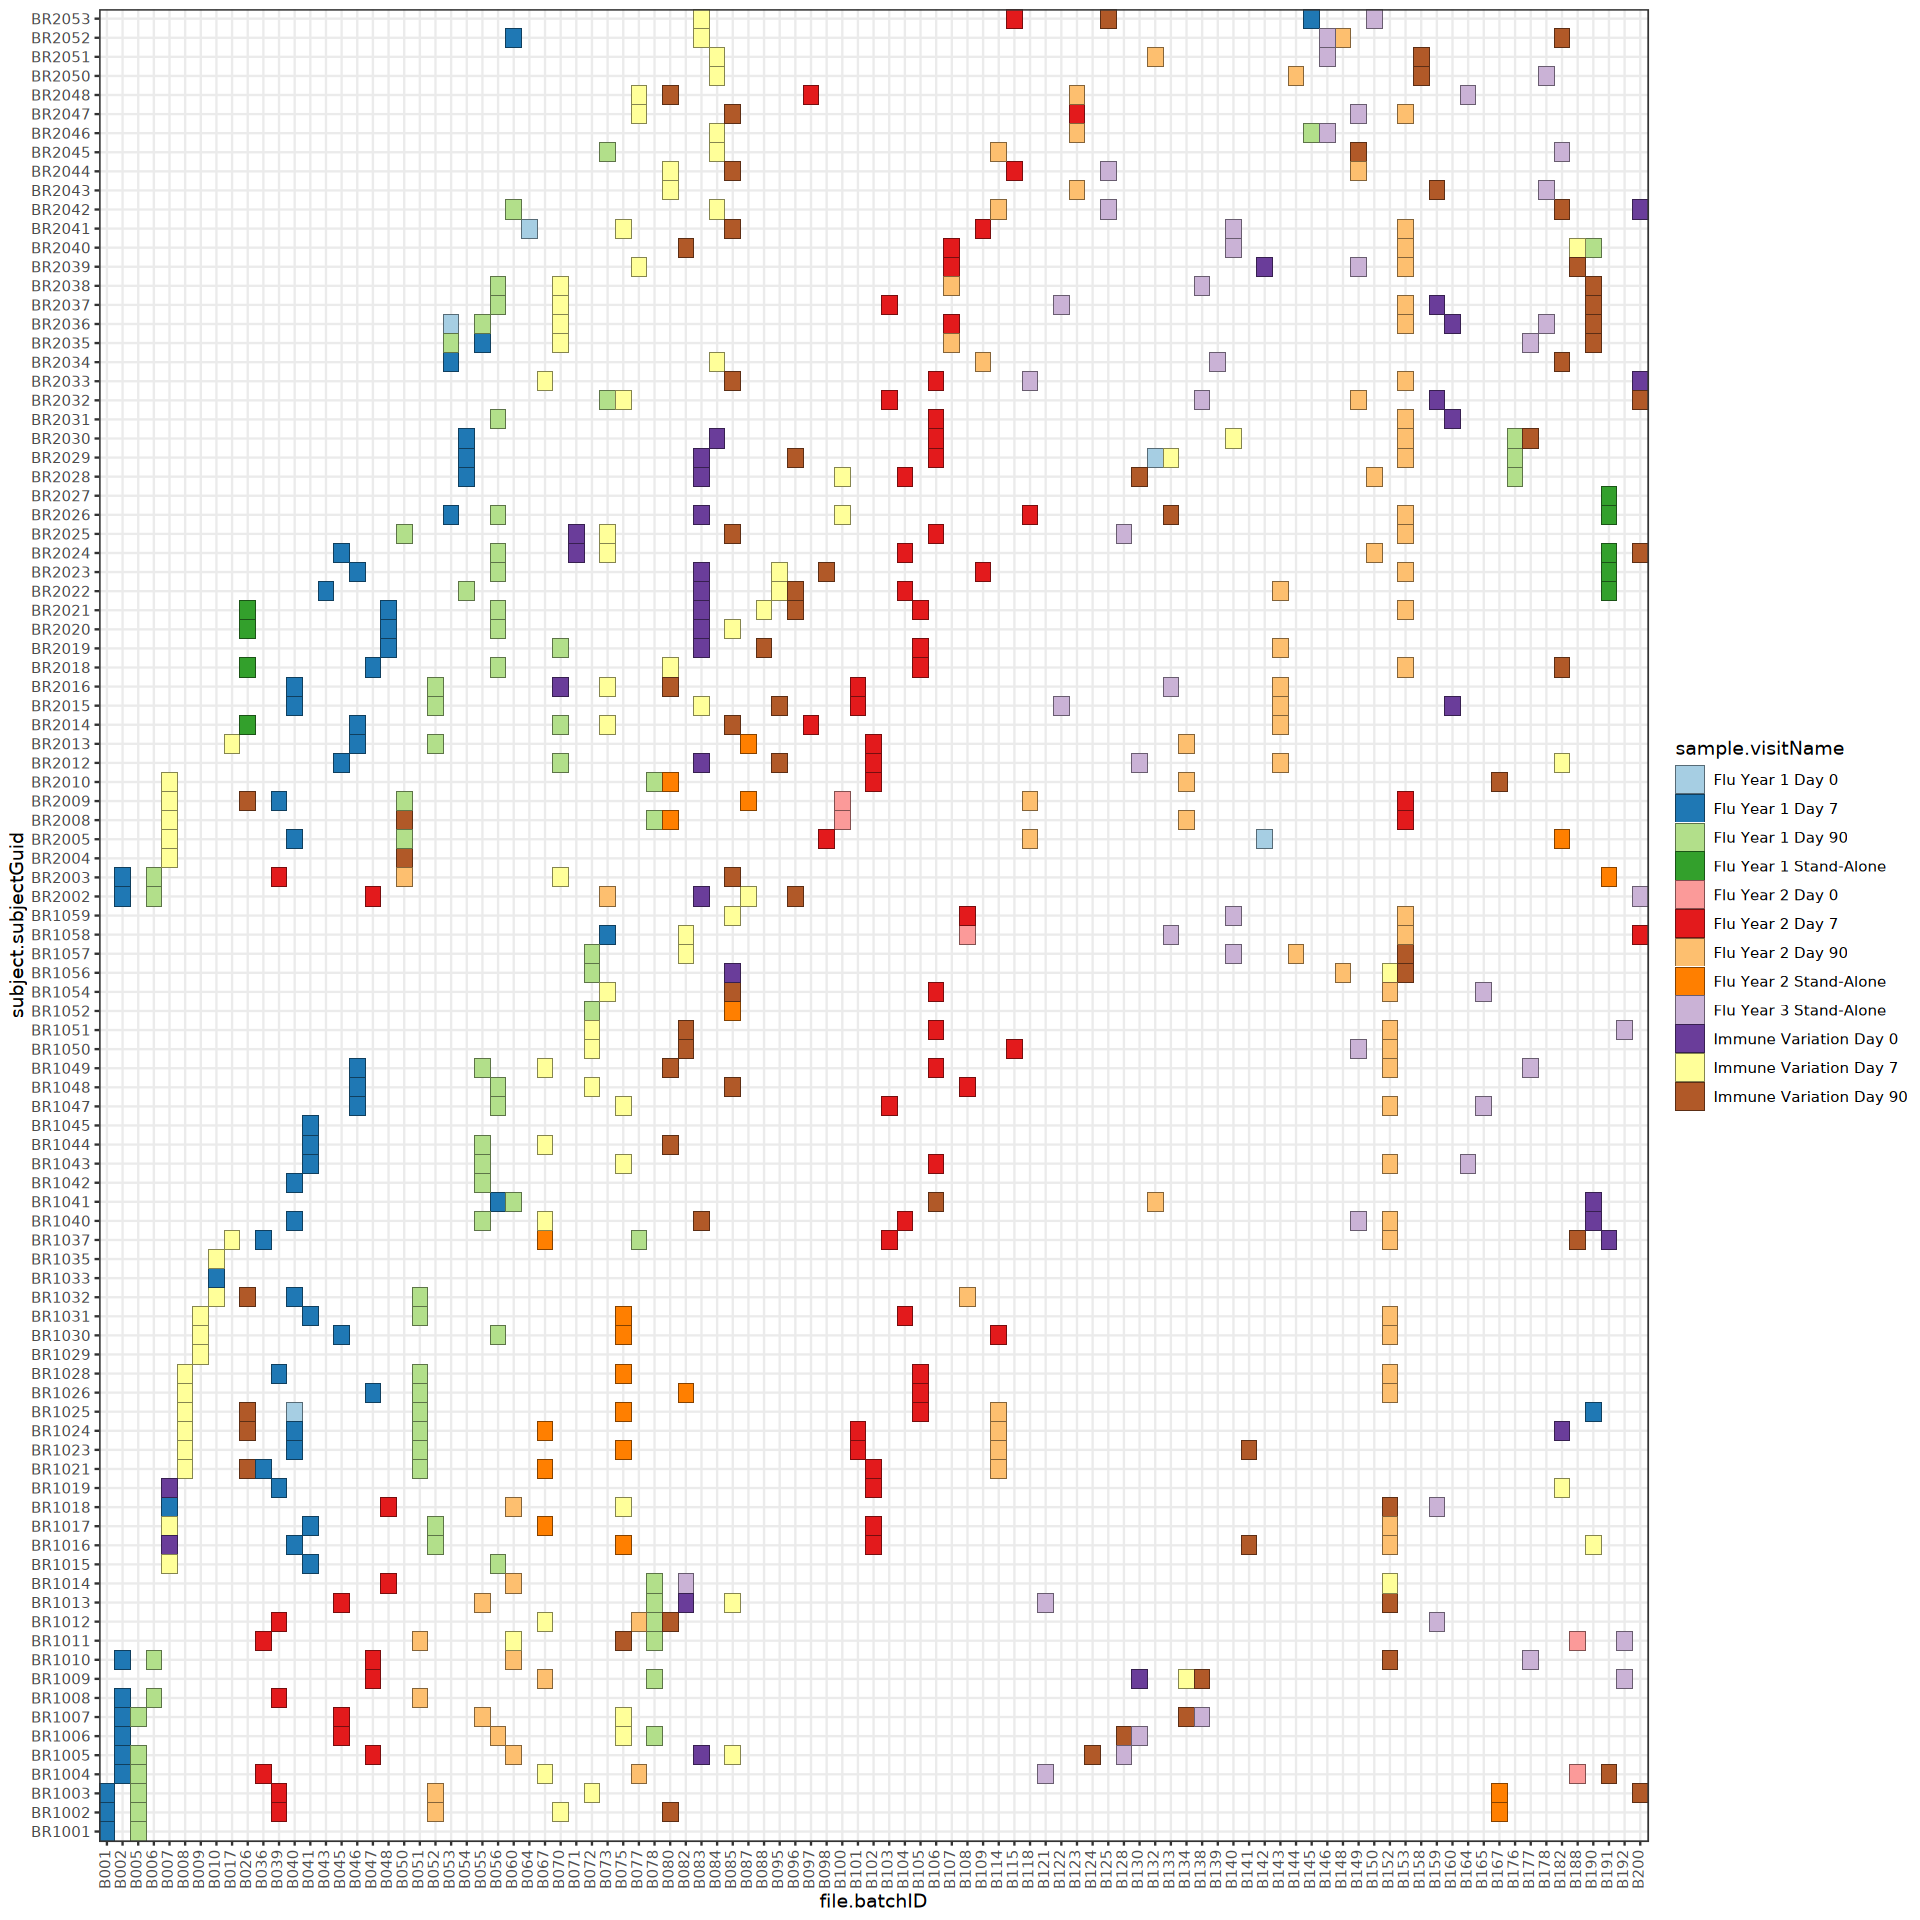

In [21]:
options(repr.plot.width = 16, repr.plot.height = 16)
ggplot() +
  geom_tile(
      data = meta_data,
      aes(x = file.batchID,
          y = subject.subjectGuid,
          fill = sample.visitName),
      color = "black"
  ) +
  scale_fill_brewer(
      type = "qual",
      palette = 3
  ) +
  scale_x_discrete(expand = c(0,0)) +
  scale_y_discrete(expand = c(0,0)) +
  theme_bw() +
  theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.3))

## Save file and sample metadata

In [22]:
if(!dir.exists("output")) {
    dir.create("output")
}

In [39]:
out_file <- file.path(
    "output",
    paste0("diha_sample_meta_data_",Sys.Date(),".csv")
)

write.csv(
    meta_data,
    out_file,
    row.names = FALSE,
    quote = FALSE
)

## Store results in HISE

In order to store the results in HISE, we'll need to cache these files to register them, and then we can upload the CSV file for later steps.

In [24]:
res <- map(
    meta_data$file.id,
    function(file.id) {
        capture.output(cacheFiles(list(file.id)))
    }
)

In [37]:
study_space_uuid <- "de025812-5e73-4b3c-9c3b-6d0eac412f2a"
title <- paste("DIHA Sample Metadata", Sys.Date())

In [26]:
in_list <- as.list(meta_data$file.id)

In [40]:
out_list <- list(out_file)

In [41]:
uploadFiles(
    files = out_list,
    studySpaceId = study_space_uuid,
    title = title,
    inputFileIds = in_list,
    store = "project",
    doPrompt = FALSE
)

[1] "Cannot determine the current notebook."
[1] "1) /home/jupyter/scRNA-Reference-IH-A/01-Sample_selection/01-Python_retrieve_cmv_bmi.ipynb"
[1] "2) /home/jupyter/IH-A-Aging-Analysis-Notebooks/scrna-seq_analysis/01-sample_selection/00-R_Sample_Selection.ipynb"
[1] "3) /home/jupyter/examples/R/XX-R Tips and tricks.ipynb"


Please select (1-3)  2


$files
$files[[1]]
[1] "output/diha_sample_meta_data_2024-03-11.csv"


$traceId
[1] "437d87c4-29aa-4089-933f-5042dd8e762d"

In [42]:
sessionInfo()

R version 4.3.2 (2023-10-31)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 20.04.6 LTS

Matrix products: default
BLAS/LAPACK: /opt/conda/lib/libopenblasp-r0.3.25.so;  LAPACK version 3.11.0

locale:
 [1] LC_CTYPE=C.UTF-8       LC_NUMERIC=C           LC_TIME=C.UTF-8       
 [4] LC_COLLATE=C.UTF-8     LC_MONETARY=C.UTF-8    LC_MESSAGES=C.UTF-8   
 [7] LC_PAPER=C.UTF-8       LC_NAME=C              LC_ADDRESS=C          
[10] LC_TELEPHONE=C         LC_MEASUREMENT=C.UTF-8 LC_IDENTIFICATION=C   

time zone: Etc/UTC
tzcode source: system (glibc)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] ggplot2_3.4.4 purrr_1.0.2   dplyr_1.1.4   hise_2.16.0  

loaded via a namespace (and not attached):
 [1] gtable_0.3.4       jsonlite_1.8.8     compiler_4.3.2     crayon_1.5.2      
 [5] Rcpp_1.0.12        tidyselect_1.2.0   IRdisplay_1.1      stringr_1.5.1     
 [9] bitops_1.0-7       assertthat_0.2.1   scal